# DATASCI Project

Prepared by: Ken Hamoy

<hr>


# Time Series Analysis on MRT3 Ridership 2017  (Jan - Dec)

### <b>OBJECTIVES</b>: Determine the peak hours and days of traffic activity and ridership in the MRT; Find outliers and trends


In [1]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from pathlib import Path
from shapely.geometry import Point

##Interactive plotly - a better alternative for matplotlib)
import chart_studio.plotly as pl
import plotly.graph_objs as go
import cufflinks as cf
import colorlover as cl

from statsmodels.stats.weightstats import ztest
from scipy.stats import chi2_contingency, ttest_1samp, ttest_ind
from scipy.stats import pearsonr, spearmanr

from plotly.graph_objs import *
pl.sign_in('kenhamoy', '5c3KHw14iNLNBuWTlahf')

#from IPython.display import HTML
%pylab inline
#%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/Users/Yomah/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['box', 'scatter', 'Annotation', 'table', 'bar', 'Figure', 'histogram', 'contour', 'histogram2d', 'pie']
`%matplotlib` prevents importing * from pylab and numpy



## Import MRT3 dataset

In [2]:
DSDATA = Path(os.getenv('DSDATA'))

In [3]:
mrt3_traffic = DSDATA / '2017_daily_hourly.csv'
df_mrt3 = pd.read_csv(mrt3_traffic)

## Check data type

In [4]:
df_mrt3.dtypes

month                  object
day                     int64
time                   object
north_avenue_entry     object
north_avenue_exit      object
quezon_avenue_entry    object
quezon_avenue_exit     object
gma_kamuning_entry     object
gma_kamuning_exit      object
cubao_entry            object
cubao_exit             object
santolan_entry         object
santolan_exit          object
ortigas_entry          object
ortigas_exit           object
shaw_blvd_entry        object
shaw_blvd_exit         object
boni_avenue_entry      object
boni_avenue_exit       object
guadalupe_entry        object
guadalupe_exit         object
buendia_entry          object
buendia_exit           object
ayala_avenue_entry     object
ayala_avenue_exit      object
magallanes_entry       object
magallanes_exit        object
taft_entry             object
taft_exit              object
dtype: object

In [5]:
for i in range(len(df_mrt3['month'])):
    df_mrt3['month'][i] = df_mrt3['month'][i].capitalize()

In [6]:
df_mrt3['month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

# Data cleaning

####  <b>1. Month order</b> 
<p> Originally, the months are arrange in alphabetical order. pandas.Categorical() will be used to arrange the months in the correct order</p>
    

In [7]:
# Arrange the months in correct order
month = ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]
df_mrt3['month'] = pd.Categorical(df_mrt3['month'], categories=month, ordered=True)

#### <b> 2. Stations datatype</b> 
<p> The datatype of the stations are converted from object to float so later on, we can easily manipulate the values. </p>

In [8]:
for x in range(3,29):
    s = df_mrt3.iloc[:, x]
    df_mrt3.iloc[:,x] = pd.to_numeric(s, errors='coerce')
    
df_mrt3.dtypes

month                  category
day                       int64
time                     object
north_avenue_entry      float64
north_avenue_exit       float64
quezon_avenue_entry     float64
quezon_avenue_exit      float64
gma_kamuning_entry      float64
gma_kamuning_exit       float64
cubao_entry             float64
cubao_exit              float64
santolan_entry          float64
santolan_exit           float64
ortigas_entry           float64
ortigas_exit            float64
shaw_blvd_entry         float64
shaw_blvd_exit          float64
boni_avenue_entry       float64
boni_avenue_exit        float64
guadalupe_entry         float64
guadalupe_exit          float64
buendia_entry           float64
buendia_exit            float64
ayala_avenue_entry      float64
ayala_avenue_exit       float64
magallanes_entry        float64
magallanes_exit         float64
taft_entry              float64
taft_exit               float64
dtype: object

Creating a column_order now will be helpful later on when creating pivot tables

In [9]:
column_order_entry=['north_avenue_entry','quezon_avenue_entry','gma_kamuning_entry','cubao_entry','santolan_entry', 'ortigas_entry', 'shaw_blvd_entry', 'boni_avenue_entry', 'guadalupe_entry', 'buendia_entry','ayala_avenue_entry' ,'magallanes_entry', 'taft_entry']   
column_order_exit=['north_avenue_exit','quezon_avenue_exit','gma_kamuning_exit','cubao_exit','santolan_exit', 'ortigas_exit', 'shaw_blvd_exit', 'boni_avenue_exit', 'guadalupe_exit', 'buendia_exit', 'ayala_avenue_exit', 'magallanes_exit', 'taft_exit']
column_order_geo=['santolan_entry','north_avenue_entry','quezon_avenue_entry','gma_kamuning_entry','cubao_entry','guadalupe_entry', 'buendia_entry' , 'magallanes_entry', 'taft_entry', 'ortigas_entry', 'shaw_blvd_entry', 'boni_avenue_entry'] 


#### <b> 3. Overall station ridership</b> 
<p> Sum of staion entries and exits per time and day</p>

In [10]:
df_mrt3['station_overall'] = df_mrt3.iloc[:, 3:].sum(axis=1)
#df_mrt3.head()


 <p><b> 3.a Overall station entries - </b> Sum of station entries per time and day</p>

In [11]:
df_mrt3['overall_entry'] =df_mrt3.iloc[:,lambda df: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]].sum(axis=1)
df_mrt3.head()

,month,day,time,north_avenue_entry,north_avenue_exit,quezon_avenue_entry,quezon_avenue_exit,gma_kamuning_entry,gma_kamuning_exit,cubao_entry,...,buendia_entry,buendia_exit,ayala_avenue_entry,ayala_avenue_exit,magallanes_entry,magallanes_exit,taft_entry,taft_exit,station_overall,overall_entry
0,January,1,04:00 - 04:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,January,1,05:00 - 05:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,January,1,06:00 - 06:59,418.0,0.0,139.0,0.0,68.0,0.0,260.0,...,11.0,25.0,18.0,57.0,6.0,31.0,0.0,1.0,1374.0,1066.0
3,January,1,07:00 - 07:59,689.0,203.0,300.0,176.0,114.0,65.0,431.0,...,97.0,80.0,250.0,290.0,301.0,164.0,1089.0,793.0,7334.0,4150.0
4,January,1,08:00 - 08:59,926.0,440.0,321.0,229.0,169.0,117.0,721.0,...,82.0,93.0,268.0,348.0,266.0,173.0,1059.0,945.0,9155.0,4890.0


<p> <b> 3.b Overall station exits - </b> Sum of station exits per time and day</p>

In [12]:
df_mrt3['overall_exit'] =df_mrt3.iloc[:,lambda df: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]].sum(axis=1)
#df_mrt3.head()

#### <b>4. Datetime</b> 
<p>Convert Month and Day to pandas.dateframe</p>

In [13]:
# Combine month and day to string
df_mrt3["date"] = df_mrt3["month"].astype(str) + " " + df_mrt3["day"].astype(str) + " 2017"
#df_mrt3["date"].unique()

In [14]:
# Convert to datetime
df_mrt3['date'] = pd.to_datetime(df_mrt3["date"])
#df_mrt3['date'].dtype

<p><b>4.a Day of the week - </b> Create day of the week dataframe for heatmap </p>

In [15]:
df_mrt3['dayofweek'] = df_mrt3['date'].dt.day_name()
#df_mrt3['dayofweek'].unique()

In [16]:
##Arrange the days in order
dayoftheweek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
df_mrt3['dayofweek'] = pd.Categorical(df_mrt3['dayofweek'], categories=dayoftheweek, ordered=True)

A column_order will be created for the heatmap

In [17]:
column_order_time = ['04:00 - 04:59','05:00 - 05:59','06:00 - 06:59','07:00 - 07:59','08:00 - 08:59','09:00 - 09:59', '10:00 - 10:59' , '11:00 - 11:59', '12:00 - 12:59', '13:00 - 13:59', '14:00 - 14:59', '15:00 - 15:59','16:00 - 16:59', '17:00 - 17:59', '18:00 - 18:59', '19:00 - 19:59', '20:00 - 20:59', '21:00 - 21:59', '22:00 - 22:59', '23:00 - 23:59']
column_order_time.reverse()

#### <b>5. Geospatial Initialization</b> 
<p>Initialize the coordinates </p>

In [18]:
# Read station shapefile
station_point = gpd.read_file(DSDATA / 'station_points/station_points.shp')
station_point.head()

,osm_id,name,public_tra,railway,geometry
0,4053127791,Santolan,station,station,POINT (121.0564313 14.60788479986099)
1,5377269277,Katipunan,station,station,POINT (121.0728557 14.63103139986371)
2,5397278996,Balintawak,station,station,POINT (121.0038417 14.65737419986682)
3,5397289144,Roosevelt Station,station,station,POINT (121.0211068 14.65750849986684)
4,5397299799,North Avenue,station,station,POINT (121.0323145 14.65217559986621)


<p> We will drop the stations that are not part of the MRT3 from the GeoDataFrame station_point </p>

In [19]:
# Drop stations that are not part of the MRT3
station_point = station_point.drop([1,2,3,5,8,10,11,12,13,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,41,42,43,44,45,46]) 
station_point


,osm_id,name,public_tra,railway,geometry
0,4053127791,Santolan,station,station,POINT (121.0564313 14.60788479986099)
4,5397299799,North Avenue,station,station,POINT (121.0323145 14.65217559986621)
6,5397300351,Quezon Avenue,station,station,POINT (121.0386466 14.64244979986506)
7,5397307742,GMA Kamuning,station,station,POINT (121.0432906 14.63534229986422)
9,5397318182,Araneta Center - Cubao,station,station,POINT (121.0526003 14.62270509986273)
15,5397307751,Guadalupe,station,station,POINT (121.0455565 14.5672104998562)
16,5397307752,Buendia,station,station,POINT (121.0341413 14.55423059985467)
17,5397312278,Magallanes,station,station,POINT (121.0194073 14.54202599985324)
36,5397312964,Taft Avenue,station,station,POINT (121.0013278 14.53754949985271)
38,5397307746,Ortigas,station,station,POINT (121.0568122 14.58789589985864)


In [20]:
# Read PH map shapefile
ph = gpd.read_file(DSDATA / 'gadm36_PHL_shp/gadm36_PHL_3.shp')
ph.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.1_1,Agtangao,None,None,Barangay,Village,None,None,"POLYGON ((120.6370162963867 17.5627002716065, ..."
1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.2_1,Angad,None,None,Barangay,Village,None,None,"POLYGON ((120.6215133666993 17.57670974731451,..."
2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.3_1,BaÃ±acao,None,None,Barangay,Village,None,None,"POLYGON ((120.5957336425782 17.60569000244141,..."
3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.4_1,Bangbangar,None,None,Barangay,Village,None,None,"POLYGON ((120.609748840332 17.60699081420904, ..."
4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,PHL.1.1.5_1,Cabuloan,None,None,Barangay,Village,None,None,"POLYGON ((120.6126937866213 17.59633064270031,..."


<p> Since the MRT3 is located in Metro Manila only, we want to specify the geospatial map to Metro Manila </p>

In [21]:
manila = ph[ph['NAME_1']=='Metropolitan Manila']

<p> Make sure both Coordinate Reference System (CRS) match </p>

In [22]:
station_point.crs

{'init': 'epsg:4326'}

In [23]:
manila.crs

{'init': 'epsg:4326'}

<p> This covers up the data cleaning. Now we will proceed to the <b>Data visualization</b> </p>

<hr>

# Data Visualization

## 1. Geospatial Visualizaation


We want to observe how the entry population changes per station hourly. First, let's get the average number of entries per station in the span of 1 year (2017).

In [25]:
mrt3_hourlystation = pd.pivot_table(df_mrt3, values=['north_avenue_entry','quezon_avenue_entry','gma_kamuning_entry','cubao_entry','santolan_entry', 'ortigas_entry', 'shaw_blvd_entry', 'boni_avenue_entry', 'guadalupe_entry', 'buendia_entry', 'ayala_avenue_entry', 'magallanes_entry', 'taft_entry'], index=['time'], aggfunc=np.mean)

#Sort the columns in the order based on the geoDataFrame station_point
mrt3_hourlystation = mrt3_hourlystation.reindex(column_order_geo, axis=1)
mrt3_hourlystation.head()

,santolan_entry,north_avenue_entry,quezon_avenue_entry,gma_kamuning_entry,cubao_entry,guadalupe_entry,buendia_entry,magallanes_entry,taft_entry,ortigas_entry,shaw_blvd_entry,boni_avenue_entry
time,,,,,,,,,,,,
04:00 - 04:59,10.825000,571.441667,187.394444,98.527778,271.113889,16.184358,1.703911,3.100840,7.137640,7.316667,57.366667,15.776536
05:00 - 05:59,96.304709,3509.201681,1363.387187,618.911357,1536.952514,605.919668,103.894737,409.659280,1454.695531,115.429363,655.803324,363.005540
06:00 - 06:59,225.609418,6001.070028,2587.589385,1121.771588,1718.952514,1523.648045,312.576177,1101.693593,3498.425770,355.448753,1461.824022,1032.621170
07:00 - 07:59,384.667590,6358.347339,2500.782123,1045.353760,1621.600559,2244.511173,431.465374,1525.217877,5449.358543,537.135734,2028.086592,1577.259777
08:00 - 08:59,368.501385,6265.938375,2275.502793,934.451253,1910.137255,2231.750700,378.911357,1485.181564,5341.238095,484.606648,1865.874302,1393.656425


/Users/Yomah/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



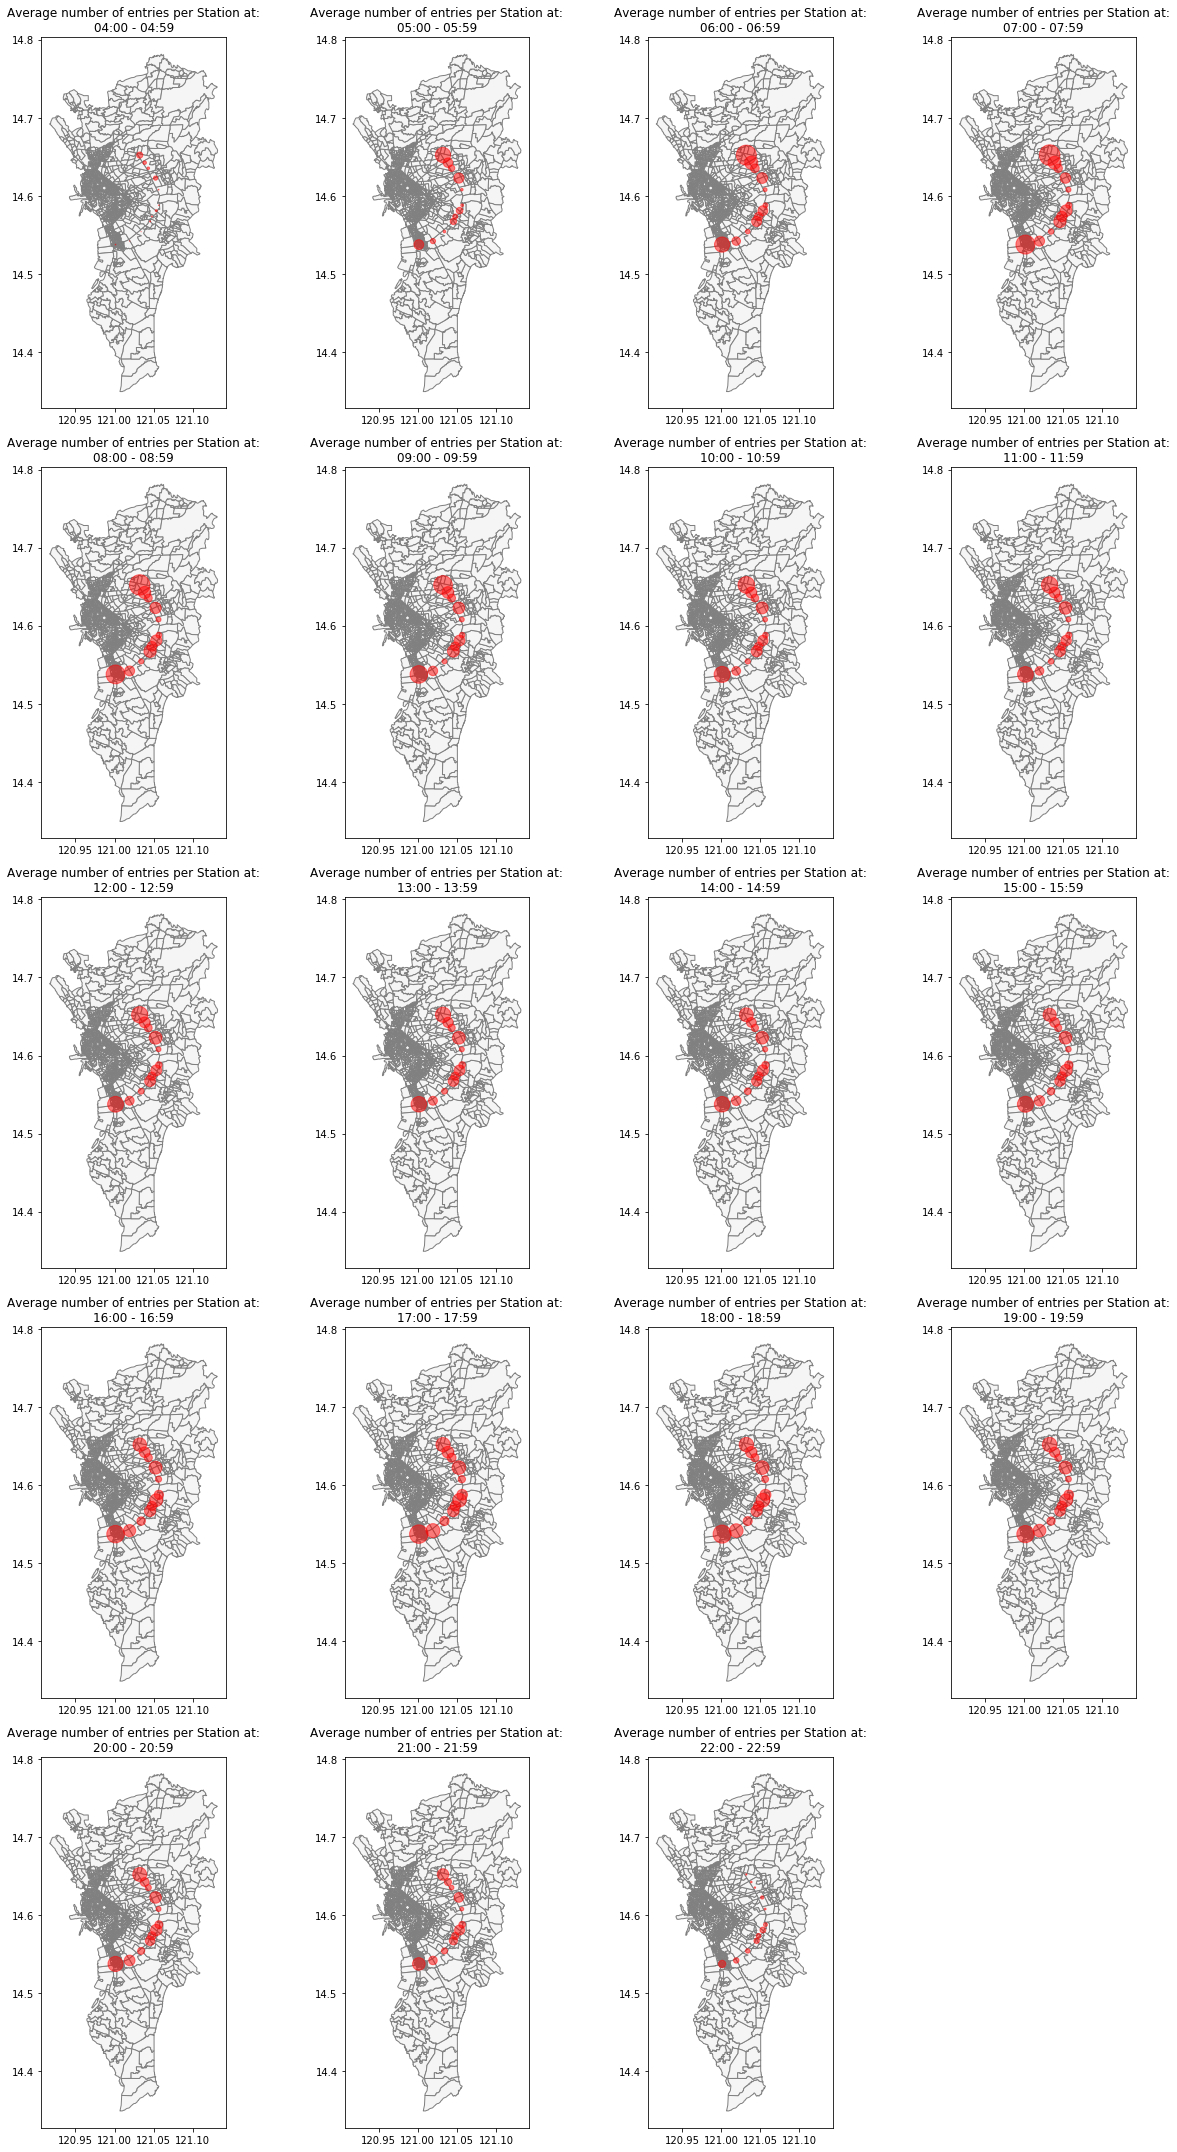

In [26]:
fig = plt.figure(figsize=(17,30))
ax = fig.add_subplot(541)


for k in range(0,19):
    array = []
    for i in range(0,12):
        array.append(mrt3_hourlystation.iloc[k,i])

    station_point['station_pop'] = array
    
    ax = plt.subplot(5,4,1+k)
    manila.plot(ax=ax, color='whitesmoke', edgecolor='gray')
    station_point.plot(ax=ax, color='red' , markersize=(station_point['station_pop']/15), alpha=0.5)
    ax.set_title('Average number of entries per Station at:\n' + mrt3_hourlystation.index[k], fontsize=12)

plt.tight_layout()

## Figure 1: Average number of entries per Station in a day
We can observe that there is always a large traffic activity at the end stations (North ave and Taft), and mid stations.


## 2. Heatmap

Now that we've looked into the average entries of each station at different times in a day, next is we want to see which times and days an average station is most congested/empty. This is best visualized  via a heatmap.

In [28]:
#Heatmap of entries & exits by Day and Hour of Day
mrt3_heatmap = pd.pivot_table(df_mrt3, values='overall_entry', index=['dayofweek'], columns=['time'], aggfunc=np.mean)
mrt3_heatmap = mrt3_heatmap.reindex(column_order_time, axis=1)
mrt3_heatmap

time,23:00 - 23:59,22:00 - 22:59,21:00 - 21:59,20:00 - 20:59,19:00 - 19:59,18:00 - 18:59,17:00 - 17:59,16:00 - 16:59,15:00 - 15:59,14:00 - 14:59,13:00 - 13:59,12:00 - 12:59,11:00 - 11:59,10:00 - 10:59,09:00 - 09:59,08:00 - 08:59,07:00 - 07:59,06:00 - 06:59,05:00 - 05:59,04:00 - 04:59
dayofweek,,,,,,,,,,,,,,,,,,,,
Monday,29.711538,3956.173077,15265.634615,21922.711538,27247.423077,30715.576923,30422.576923,25275.519231,21496.461538,19894.307692,19758.942308,20720.538462,20807.115385,21276.961538,23790.134615,26994.307692,27652.211538,22983.673077,13243.076923,1784.250000
Tuesday,29.038462,4652.480769,17066.038462,23801.134615,30022.961538,34532.538462,34542.173077,27757.269231,22723.519231,21036.134615,21130.173077,22460.038462,22231.096154,22864.750000,26729.673077,30720.769231,32975.461538,26892.673077,13732.269231,1574.134615
Wednesday,40.461538,4926.692308,18155.634615,24900.519231,30567.769231,34160.461538,33592.076923,28266.192308,23511.942308,21493.673077,21680.826923,22756.211538,22575.673077,22995.153846,26726.615385,30912.384615,33036.096154,26850.634615,13140.423077,1375.403846
Thursday,39.862745,5005.588235,17422.666667,23405.823529,29138.921569,33253.235294,33104.745098,27442.607843,22512.882353,20841.725490,20775.784314,21723.882353,21506.078431,21996.392157,25497.235294,29896.294118,32058.607843,26066.176471,12983.176471,1564.156863
Friday,32.000000,6848.568627,18831.627451,25779.862745,31727.098039,34819.196078,36113.666667,30672.666667,25875.019608,23924.666667,23538.137255,24576.215686,23105.705882,23164.921569,26734.647059,30124.019608,32344.843137,26386.647059,12486.294118,1245.000000
Saturday,21.764706,4236.823529,11312.549020,15529.215686,20240.901961,23595.607843,25869.156863,25186.921569,21546.784314,19859.901961,20209.843137,21436.843137,18468.176471,17233.901961,19145.980392,19579.313725,19149.392157,15115.490196,7921.568627,746.274510
Sunday,25.519231,2319.461538,9542.711538,11728.807692,13747.807692,14617.961538,15070.288462,15169.653846,14384.326923,13694.153846,13477.134615,13860.403846,13884.153846,12766.576923,13059.480769,11550.211538,8976.576923,7006.711538,4137.346154,454.826923


In [29]:
#Plot heatmap
mrt3_heatmap.iplot(kind='heatmap', colorscale='OrRd', title="Average commuter traffic at each station at different times in a day")

/Users/Yomah/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Figure 2: Average commuter traffic at each station at different times in a day 
We can observe here that the most congested hours in a station are start and end of working hours. Furthermore, the peak day is friday, and the least busiest is sunday

## Line Graph

In [45]:
#Pivot table
mrt3_2017ridership_entry = pd.pivot_table(df_mrt3, values=['north_avenue_entry','quezon_avenue_entry','gma_kamuning_entry','cubao_entry','santolan_entry', 'ortigas_entry', 'shaw_blvd_entry', 'boni_avenue_entry', 'guadalupe_entry', 'buendia_entry', 'ayala_avenue_entry', 'magallanes_entry', 'taft_entry'], index=['date'], aggfunc=np.sum)
mrt3_2017ridership_entry = mrt3_2017ridership_entry.reindex(column_order_entry, axis=1)

mrt3_2017ridership_exit = pd.pivot_table(df_mrt3, values=['north_avenue_exit','quezon_avenue_exit','gma_kamuning_exit','cubao_exit','santolan_exit', 'ortigas_exit', 'shaw_blvd_exit', 'boni_avenue_exit', 'guadalupe_exit', 'buendia_exit', 'ayala_avenue_exit', 'magallanes_exit', 'taft_exit'], index=['date'], aggfunc=np.sum)
mrt3_2017ridership_exit = mrt3_2017ridership_exit.reindex(column_order_exit, axis=1)

mrt3_totalaverage_entry = pd.pivot_table(df_mrt3, values='overall_entry', index=['date'], aggfunc=np.average)


In [38]:
##Station entries in the span of Jan to December 2017

##PLOTLY VERSION
fig = go.Figure()
cf.set_config_file(offline=False, world_readable=True, theme='white')
mrt3_2017ridership_entry.iplot(kind='scatter',  title = 'MRT3 2017 Monthly - Daily Ridership (Entries) ')


##MATPLOTLIB VERSION

#fig = plt.figure(figsize=(22,5))
#ax = fig.add_subplot(111)

#ax.plot(mrt3_2017ridership_entry, '-', ms=10 )

#ax.set_xlabel("Date", fontsize=12)
#ax.set_ylabel("Number of enntries", fontsize=12)
#ax.set_title("MRT3 2017 Monthly - Daily Ridership (Entries)", fontsize=15)

#plt.legend(bbox_to_anchor=(0, 1.15, 0.77, .102))

/Users/Yomah/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Figure 3: MRT3 Monthly - Daily Entries per station from 2017-01-01 to 2017-12-31

There are two observations that can be made here:
    1. Traffic activity is most congested at the end stations. 
    2. The least commuter traffic activity is found at Santolan station and GMA Kamuning station


Next, let's plot the total average entries of all stations

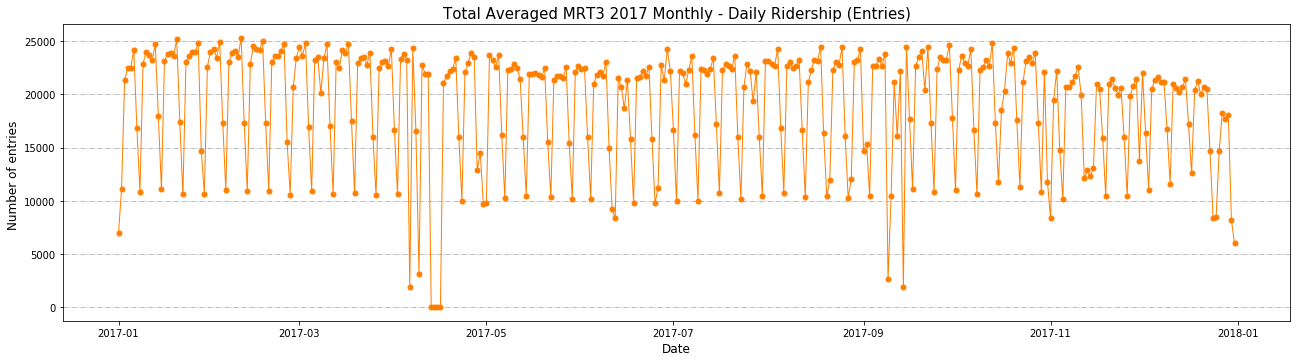

In [80]:
mrt3_totalaverage_entry_rolling = mrt3_totalaverage_entry.rolling(center=False, axis=0, window=10).mean()

fig = plt.figure(figsize=(22,12))
ax = fig.add_subplot(211)


ax.plot(mrt3_totalaverage_entry, '.-', ms=10, color='#FF7F00', linewidth=1 )


ax.set_title("Total Averaged MRT3 2017 Monthly - Daily Ridership (Entries)", fontsize=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of entries ", fontsize=12)
ax.grid(axis='y', linestyle='-.');




## Figure 4: Total Averaged MRT3  Monthly - Daily Entries from 2017-01-01 to 2017-12-31

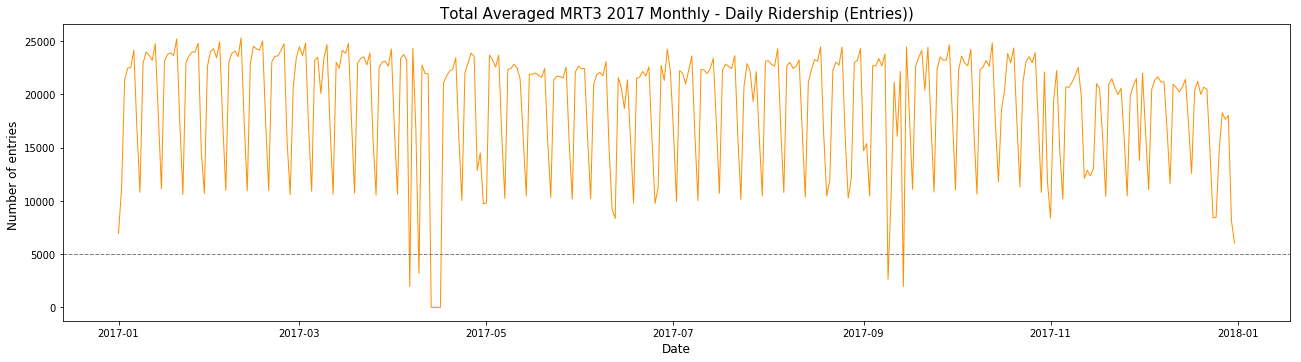

In [81]:
mrt3_totalaverage_entry_rolling = mrt3_totalaverage_entry.rolling(center=False, axis=0, window=10).mean()
mrt3_totalaverage_entry_mean = mrt3_totalaverage_entry.mean()

fig = plt.figure(figsize=(22,12))
ax = fig.add_subplot(211)


ax.plot(mrt3_totalaverage_entry, '-', ms=10, color='#FF8F00', linewidth=1, label = 'leo' )

ax.set_title("Total Averaged MRT3 2017 Monthly - Daily Ridership (Entries))", fontsize=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of entries ", fontsize=12)
plt.axhline(y=5000, linestyle ='--', color='gray', linewidth=1)
#plt.axvline(x='2017-09-14', linestyle ='--', color='red', linewidth=1)

## Figure 5: Total Averaged MRT3  Monthly - Daily Entries from 2017-01-01 to 2017-12-31 Outliers

We can see that there are outliers on the dats 2017-04, and 2017-09. A quick research is done to see what events happened during the said dates  and why these dates have lower entries than the usual pattern.

Reference: https://www.rappler.com/nation/166298-lrt-mrt-pnr-schedule-holy-week-2017
        
In the Rappler article, we can see that the dates mentioned are April 13-16, 2017 (Easter) which is  more or less matches the dataset. However, We coudn't find events that might have caused the sudden drops in 2017-09 in our dataset.

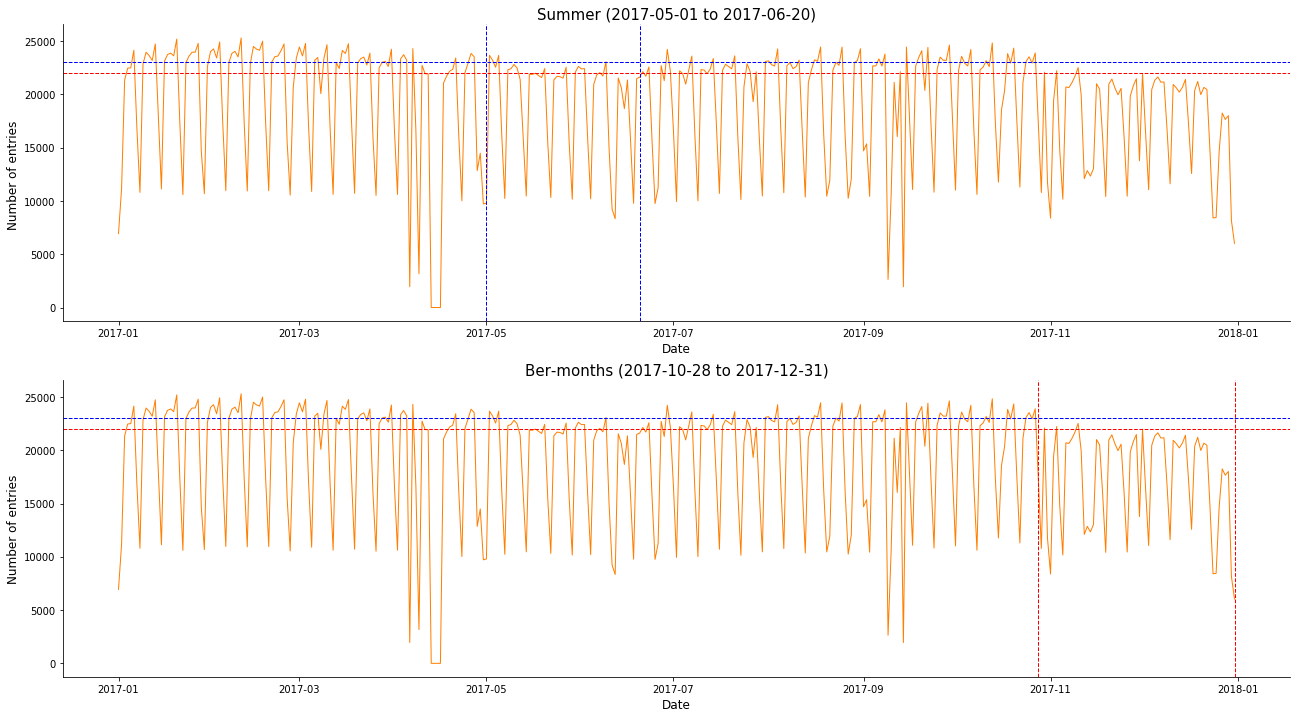

In [55]:
fig = plt.figure(figsize=(22,12))
ax = fig.add_subplot(211)


ax.plot(mrt3_totalaverage_entry, '-', ms=10, color='#FF7F00', linewidth=1 )
ax.set_title("Summer (2017-05-01 to 2017-06-20)", fontsize=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of entries ", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axhline(y=23000, linestyle ='--', color='blue', linewidth=1)
plt.axhline(y=22000, linestyle ='--', color='red', linewidth=1)
plt.axvline(x='2017-05-01', linestyle ='--', color='blue', linewidth=1)
plt.axvline(x='2017-06-20', linestyle ='--', color='blue', linewidth=1)

ax = plt.subplot(2,1,2) 
ax.plot(mrt3_totalaverage_entry, '-', ms=10, color='#FF7F00', linewidth=1 )
ax.set_title("Ber-months (2017-10-28 to 2017-12-31)", fontsize=15)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of entries", fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axhline(y=23000, linestyle ='--', color='blue', linewidth=1)
plt.axhline(y=22000, linestyle ='--', color='red', linewidth=1)
plt.axvline(x='2017-10-28', linestyle ='--', color='red', linewidth=1)
plt.axvline(x='2017-12-31', linestyle ='--', color='red', linewidth=1)


## Figure 6: Total Averaged MRT3 Entries in Summer and ber-months
What we can also observe the in the two plots above is that there are less commuters during Summer (Apr-Jun) and Ber-months (Nov-Dec) versus the other months.


Based on the observations made, we can now formualate a few hypotheses. 

<hr>

# Hypothesis Testing

### Significance level $\alpha = 5%$

1. The entry population at the End Stations (Taft and North) are significantly larger than that of the average entries of all stations
2. The station congestion (Entry) on Fridays is significantly higher than on the other days of the week
3. Stations are busiest at the the start and end of working hours versus other times in the day.
4. There are less commuters during Summer (Apr-Jun) and Ber-months (Nov-Dec)versus the other months.</p>

We will be using statistical tools to test each one by one


In [53]:
pop_mean = df_mrt3['overall_entry'].mean()
sample = df_mrt3['taft_entry']
sample.head()

0       0.0
1       0.0
2       0.0
3    1089.0
4    1059.0
Name: taft_entry, dtype: float64

In [64]:
tstat, pval = ztest(df_mrt3['taft_entry'],
                    value=pop_mean, )

print('{:.6f}'.format(tstat))
print('{:.6f}'.format(pval))

nan
nan


## The station congestion (Entry) on Fridays is significantly higher than on the other days of the week

$H_0$: Our null hypothesis states that traffic activity on Fridays is less than  the average day of the week

$H_a$: Our alternative hypothesis states that traffic activity on Fridays is significantly larger than  the average day of the week

In [54]:
tstat, pval = ztest(df_mrt3[df_mrt3['dayofweek'] == 'Friday']['overall_entry'],
                    value=pop_mean,  )

print('{:.6f}'.format(tstat))
print('{:.6f}'.format(pval))

10.188084
0.000000


In [55]:
if pval < 0.05:
        print('Traffic activity on Fridays is significantly greater than  the average day of the week')
else:
        print('Traffic activity don Fridays is less than  the average day of the week')

Traffic activity on Fridays is significantly greater than  the average day of the week


The p-value is less than the the significance level, therefore we can safely reject the null hypothesis and conclude that traffic activity on Fridays is significantly greater than  the average day of the week.

The same tests were done for the other hypotheses

## Stations are busiest at the the start and end of working hours versus other times in the day.

$H_0$: Our null hypothesis states that commuter traffic activity during peak hours is less than or equal to the average operating hours

$H_a$: Our alternative hypothesis states that commuter traffic activity during peak hours is significantly greater than the average operating hours

In [74]:
tstat, pval = ztest(df_mrt3[df_mrt3['time'] == '07:00 - 07:59']['overall_entry'],
                    value=pop_mean,  )

print('{:.6f}'.format(tstat))
print('{:.6f}'.format(pval))

13.551163
0.000000


In [75]:
if pval < 0.05:
        print('Traffic activity during peak hours (morning) is significantly greater than the average operating hours')
else:
        print('Traffic activity during peak hours (morning) is less than the average operating hours')

Traffic activity during peak hours (morning) is significantly greater than the average operating hours


In [76]:
tstat, pval = ztest(df_mrt3[df_mrt3['time'] == '19:00 - 19:59']['overall_entry'],
                    value=pop_mean,  )

print('{:.6f}'.format(tstat))
print('{:.6f}'.format(pval))

17.263694
0.000000


In [77]:
if pval < 0.05:
        print('Traffic activity during peak hours (afternoon) is significantly greater than the average operating hours')
else:
        print('Traffic activity during peak hours (afternoon) is  less than the average operating hours')

Traffic activity during peak hours (afternoon) is significantly greater than the average operating hours


## Conclusions

1. Commuter traffic is most congested at end stations
2. 7AM-8AM and 5PM-6PM are the busiest hours 
3. Friday is the worst day to ride the MRT3



## Recommendations

Skip trains can be reinforced during peak hours to prioritize the end stations and opt to skip Santolan and GMA Kamuning stations due to their low commuter traffic activity.

